<a href="https://colab.research.google.com/github/audreyemmely/comp-evolucionaria/blob/main/tsp_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **O problema**

Nesse notebook, usaremos um AG para encontrar uma solução para o problema do caixeiro viajante (travelling salesman problem, TSP). O TSP é descrito da seguinte forma:

*“Dada uma lista de cidades e as distâncias entre cada par de cidades, qual é o trajeto mais curto possível que visita cada cidade e retorna à cidade de origem?”*

![image.png](https://miro.medium.com/max/512/1*DwB6K0KKNug7-y59Uowhsg.png)

Com isso, há duas regras importantes para manter em mente:
1.   Cada cidade precisa ser visitada exatamente uma vez
2.   Devemos retornar à cidade de partida, então nossa distância total precisa ser calculada de acordo

# **A abordagem**



*   Gene: uma cidade (representada como coordenadas (x, y))
*   Indivíduo (também conhecido como "cromossomo"): uma única rota que satisfaça as condições acima
*   População: uma coleção de rotas possíveis (ou seja, coleção de indivíduos)
*   Pais: duas rotas que são combinadas para criar uma nova rota
*   Pool de acasalamento (mating): uma coleção de pais que são usados ​​para criar nossa próxima população (criando assim a próxima geração de rotas)
*   Fitness: uma função que nos diz o quão bom é cada trajeto (no nosso caso, quão curta é a distância)
*   Mutação: uma forma de introduzir variação em nossa população trocando aleatoriamente duas cidades em uma rota
*   Elitismo: uma forma de transportar os melhores indivíduos para a próxima geração

Nosso AG prosseguirá nas seguintes etapas:


1.   Crie a população
2.   Determine o fitness
3.   Selecione o pool de acasalamento
4.   Faça o cruzamento
5.   Faça a mutação
6.   Repita



# **Construindo o algoritmo genético**

Primeiro vamos importar as bibliotecas que serão utilizadas

In [ ]:
import numpy as np
import pandas as pd
import random
import operator
import matplotlib.pyplot as plt

### Criando as classes "Cidade" e "Fitness"

A classe ```cidade``` nos permitirá criar e administrar as cidades. Estas são simplesmente nossas coordenadas (x, y). 

Dentro da classe ```cidade```, criamos a função ```distancia```, para calcular a distância usando o teorema de Pitágoras. E também criamos a função  ```__repr__``` para termos uma maneira mais limpa de gerar as cidades como coordenadas.

In [ ]:
class Cidade:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distancia(self, cidade):
        xDis = abs(self.x - cidade.x)
        yDis = abs(self.y - cidade.y)
        distancia = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distancia
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

No nosso caso, a classe ```fitness``` será o inverso da distância da rota. Queremos minimizar a distância da rota, então uma pontuação de fitness maior é melhor. Com base na regra nº 2, precisamos começar e terminar no mesmo lugar, portanto, esse cálculo extra é contabilizado em ```if i + 1 < len(self.rota): cidadeDeChegada = self.rota[i + 1]```.

In [ ]:
class Fitness:
    def __init__(self, rota):
        self.rota = rota
        self.distancia = 0
        self.fitness = 0.0
    
    def rotaDistancia(self):
        if self.distancia ==0:
            caminhoDistancia = 0
            for i in range(0, len(self.rota)):
                cidadeDePartida = self.rota[i]
                cidadeDeChegada = None
                if i + 1 < len(self.rota):
                    cidadeDeChegada = self.rota[i + 1]
                else:
                    cidadeDeChegada = self.rota[0]
                caminhoDistancia += cidadeDePartida.distancia(cidadeDeChegada)
            self.distancia = caminhoDistancia
        return self.distancia
    
    def rotaFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.rotaDistancia())
        return self.fitness

### Criando a população


Agora vamos criar nossa população inicial (também conhecida como primeira geração). Para fazer isso, precisamos criar uma função que produza rotas que satisfaçam nossas condições (obs.: vamos criar a lista de cidades quando executarmos o AG posteriormente). Para criar um indivíduo, selecionamos aleatoriamente a ordem em que visitamos cada cidade.

In [ ]:
def criarRota(listaDeCidades):
  rota = random.sample(listaDeCidades, len(listaDeCidades))
  return rota

Isso produz um indivíduo, mas queremos uma população completa, então vamos fazer isso na próxima função. Iremos percorrer a função ```criarRota``` até que tenhamos quantas rotas quisermos para nossa população.

In [ ]:
def populacaoInicial(tamPop, listaDeCidades):
    populacao = []

    for i in range(0, tamPop):
        populacao.append(criarRota(listaDeCidades))
    return populacao

### Determinando fitness

Para simular a “sobrevivência do mais apto”, usamos ```Fitness``` para classificar cada indivíduo na população. A saída será uma lista ordenada com os IDs de rota e cada pontuação de fitness associada.

In [ ]:
def rankRota(populacao):
    fitnessResultado = {}
    for i in range(0,len(populacao)):
        fitnessResultado[i] = Fitness(populacao[i]).rotaFitness()
    return sorted(fitnessResultado.items(), key = operator.itemgetter(1), reverse = True)

### Selecionando o pool de acasalamento (mating)

Existem algumas opções de como selecionar os pais que serão usados ​​para criar a próxima geração. As abordagens mais comuns são a seleção proporcional de aptidão (também conhecida como "seleção da roda de roleta") ou a seleção por torneio:
*   Seleção proporcional de aptidão (a versão implementada abaixo): a aptidão (fitness) de cada indivíduo em relação à população é usada para atribuir uma probabilidade de seleção. 
*   Seleção por torneio: um determinado número de indivíduos é selecionado aleatoriamente da população e aquele com a maior aptidão do grupo é escolhido como o primeiro pai. Isso é repetido para escolher o segundo pai.

Outro recurso a ser considerado é o uso de elitismo. Com o elitismo, os indivíduos de melhor desempenho da população serão automaticamente transferidos para a próxima geração, garantindo que os indivíduos mais bem-sucedidos persistam.

Criaremos o pool de acasalamento em duas etapas. Primeiro, usaremos a saída de ```rankRota``` para determinar quais rotas selecionar na função ```selecao```. Configuramos a roda da roleta calculando um peso de aptidão relativo para cada indivíduo. Comparamos um número sorteado aleatoriamente com esses pesos para selecionar nosso pool de acasalamento. Também queremos manter nossas melhores rotas, portanto, introduzimos o elitismo. Por fim, a função ```selecao``` retorna uma lista de IDs de rota, que podemos usar para criar o pool de acasalamento na função ```poolAcasalamento```.

In [ ]:
def selecao(popRankeada, tamElite):
    selecaoResultado = []
    df = pd.DataFrame(np.array(popRankeada), columns=["Index","Fitness"])
    df['cum_soma'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_soma/df.Fitness.sum()
    
    for i in range(0, tamElite):
        selecaoResultado.append(popRankeada[i][0])
    for i in range(0, len(popRankeada) - tamElite):
        escolha = 100*random.random()
        for i in range(0, len(popRankeada)):
            if escolha <= df.iat[i,3]:
                selecaoResultado.append(popRankeada[i][0])
                break
    return selecaoResultado

Agora que temos os IDs das rotas que formarão nosso pool de acasalamento a partir da função ```selecao```, podemos criar o pool de acasalamento. Estamos simplesmente extraindo os indivíduos selecionados de nossa população.

In [ ]:
def poolAcasalamento(populacao, selecaoResultado):
    poolacasalamento = []
    for i in range(0, len(selecaoResultado)):
        index = selecaoResultado[i]
        poolacasalamento.append(populacao[index])
    return poolacasalamento

### Crossover

Com o pool de acasalamento criado, podemos criar a próxima geração em um processo chamado crossover (também conhecido como “cruzamento”). Se nossos indivíduos fossem sequências de 0s e 1s e nossas duas regras não se aplicassem, poderíamos simplesmente escolher um ponto de cruzamento e unir as duas sequências para produzir uma prole.
No entanto, no problema do caixeiro viajante precisamos incluir todos os locais exatamente uma vez. Para obedecer a essa regra, podemos usar uma função de criação especial chamada crossover ordenado. No cruzamento ordenado, selecionamos aleatoriamente um subconjunto da primeira string pai e, em seguida, preenchemos o restante da rota com os genes do segundo pai na ordem em que aparecem, sem duplicar quaisquer genes no subconjunto selecionado do primeiro pai.

![image](https://slidetodoc.com/presentation_image_h/29be5a01446c578c89ee11b4fa597dcb/image-8.jpg)

In [ ]:
def crossover(pai1, pai2):
    filho = []
    filhoP1 = []
    gilhoP2 = []
    
    geneA = int(random.random() * len(pai1))
    geneB = int(random.random() * len(pai1))
    
    inicioGene = min(geneA, geneB)
    fimGene = max(geneA, geneB)

    for i in range(inicioGene, fimGene):
        filhoP1.append(pai1[i])
        
    filhoP2 = [item for item in pai2 if item not in filhoP1]

    filho = filhoP1 + filhoP2
    return filho

Agora, generalizaremos isso para criar nossa população de descendentes. Usamos o elitismo para reter as melhores rotas da população atual. Então, usamos a função ```crossover``` para preencher o restante da próxima geração.

In [ ]:
def crossoverPopulacao(poolAcasalamento, tamElite):
    filhos = []
    comp = len(poolAcasalamento) - tamElite
    pool = random.sample(poolAcasalamento, len(poolAcasalamento))

    for i in range(0, tamElite):
        filhos.append(poolAcasalamento[i])
    
    for i in range(0, comp):
        filho = crossover(pool[i], pool[len(poolAcasalamento)-i-1])
        filhos.append(filho)
    return filhos

### Mutação

A mutação tem uma função importante em AG, pois ajuda a evitar a convergência local, introduzindo novas rotas que nos permitirão explorar outras partes do espaço de solução. Semelhante ao crossover, o problema do caixeiro viajante tem uma consideração especial quando se trata de mutação. Novamente, se tivéssemos um cromossomo de 0s e 1s, a mutação significaria simplesmente atribuir uma baixa probabilidade de um gene mudar de 0 para 1, ou vice-versa.

No entanto, como precisamos cumprir com as regras, não podemos abandonar as cidades. Em vez disso, usaremos a mutação utilizando a técnica de troca (swap). Isso significa que, com baixa probabilidade especificada, duas cidades trocarão de lugar em nossa rota. Faremos isso para um indivíduo na função ```mutacao```.

In [ ]:
def mutacao(individuo, taxaMutacao):
    for trocado in range(len(individuo)):
        if(random.random() < taxaMutacao):
            trocaCom = int(random.random() * len(individuo))
            
            cidade1 = individuo[trocado]
            cidade2 = individuo[trocaCom]
            
            individuo[trocado] = cidade2
            individuo[trocaCom] = cidade1
    return individuo

Em seguida, podemos estender a função ```mutacao``` para percorrer a nova população.

In [ ]:
def mutacaoPopulacao(populacao, taxaMutacao):
    popPosMutacao = []
    
    for ind in range(0, len(populacao)):
        indPosMutacao = mutacao(populacao[ind], taxaMutacao)
        popPosMutacao.append(indPosMutacao)
    return popPosMutacao

### Repetição
Vamos juntar tudo isso para criar uma função que produza uma nova geração. Primeiro, classificamos as rotas na geração atual usando ```rankRota```. Em seguida, determinamos os pais em potencial executando a função ```selecao```, o que nos permite criar o pool de acasalamento usando a função ```poolAcasalamento```. Por fim, criamos a nova geração usando a função ```crossoverPopulacao``` e, em seguida, aplicamos a mutação usando a função  ```mutacaoPopulacao```.

In [ ]:
def proxGeracao(atualGeracao, tamElite, taxaMutacao):
    popRankeada = rankRota(atualGeracao)
    selecaoResultado = selecao(popRankeada, tamElite)
    poolacasalamento = poolAcasalamento(atualGeracao, selecaoResultado)
    filhos = crossoverPopulacao(poolacasalamento, tamElite)
    proxGeracao = mutacaoPopulacao(filhos, taxaMutacao)
    return proxGeracao

### Criação da função AG

Agora, só precisamos criar a população inicial e, então, poderemos passar por quantas gerações desejarmos. Como também queremos ver a melhor rota e o quanto melhoramos, capturamos a distância inicial (a distância é o inverso do fitness), a distância final e a melhor rota.

In [ ]:
def algoritmoGenetico(populacao, tamPop, tamElite, taxaMutacao, geracoes):
    pop = populacaoInicial(tamPop, populacao)
    print("Distância inicial: " + str(1 / rankRota(pop)[0][1]))
    
    for i in range(0, geracoes):
        pop = proxGeracao(pop, tamElite, taxaMutacao)
    
    print("Distância final: " + str(1 / rankRota(pop)[0][1]))
    melhorRotaIndex = rankRota(pop)[0][0]
    melhorRota = pop[melhorRotaIndex]
    return melhorRota

# **Rodando o algoritmo genético**

Primeiro, precisamos de uma lista de cidades entre as quais viajar. Para esta demonstração, criamos uma lista de 25 cidades aleatórias.

In [ ]:
listaDeCidades = []

for i in range(0,25):
    listaDeCidades.append(Cidade(x=int(random.random() * 200), y=int(random.random() * 200)))

Então, a execução do algoritmo genético é uma linha de código. Neste exemplo, temos 100 indivíduos em cada geração, mantemos 20 indivíduos de elite, usamos uma taxa de mutação de 1% para um determinado gene e percorremos 500 gerações.

In [ ]:
algoritmoGenetico(populacao=listaDeCidades, tamPop=100, tamElite=20, taxaMutacao=0.01, geracoes=500)

Distância inicial: 2005.1378469627664
Distância final: 826.0343490564437


[(97,198),
 (79,150),
 (87,139),
 (109,165),
 (192,172),
 (199,170),
 (162,137),
 (171,111),
 (153,123),
 (129,103),
 (156,91),
 (167,84),
 (152,50),
 (109,54),
 (112,40),
 (73,21),
 (53,19),
 (44,21),
 (78,111),
 (65,116),
 (41,125),
 (22,121),
 (23,186),
 (48,183),
 (51,184)]

### Melhorando a visualização dos dados: Plotando a melhoria da distância 

Ao notarmos como a distância melhorou com o tempo, ajustamos a função ```algoritmoGenetico```, armazenando a distância mais curta de cada geração em uma lista de progresso, e em seguida plotamos os resultados.

In [ ]:
def plotAlgoritmoGenetico(populacao, tamPop, tamElite, taxaMutacao, geracoes):
    pop = populacaoInicial(tamPop, populacao)
    progresso = []
    progresso.append(1 / rankRota(pop)[0][1])
    
    for i in range(0, geracoes):
        pop = proxGeracao(pop, tamElite, taxaMutacao)
        progresso.append(1 / rankRota(pop)[0][1])
  
    plt.plot(progresso)
    plt.ylabel('Distância')
    plt.xlabel('Geração')
    plt.show()

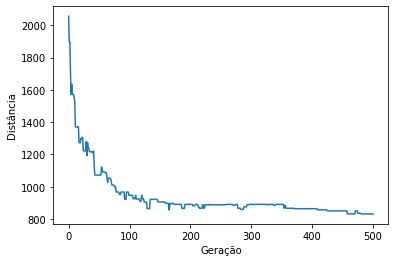

In [ ]:
plotAlgoritmoGenetico(populacao=listaDeCidades, tamPop=100, tamElite=20, taxaMutacao=0.01, geracoes=500)


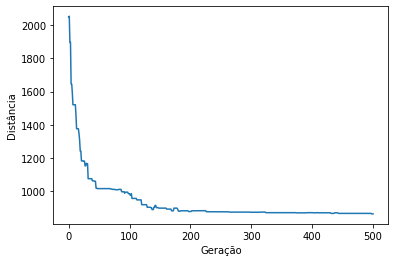

In [ ]:
plotAlgoritmoGenetico(populacao=listaDeCidades, tamPop=100, tamElite=20, taxaMutacao=0.005, geracoes=500)


# Referências

http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5

https://gist.github.com/turbofart/3428880

https://gist.github.com/NicolleLouis/d4f88d5bd566298d4279bcb69934f51d

https://pt.wikipedia.org/wiki/Problema_do_caixeiro-viajante
